In [46]:
SEQ_LEN = 12
FORECAST_HORIZON = 3
MULTI_HORIZON = True
INPUT_DIM = 1
CONV_OUTPUT_DIM = 8
LSTM_HID_DIM = 32
TRAIN_VALID_RATIO = 0.7
SEED = 42

In [67]:
import random
import pandas as pd
import chores
import torch
import numpy as np
from utils import GraphTimeSeriesDataset, compute_adjacency_matrix
from models import GCN_LSTM
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.random.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [54]:
route_distances = pd.read_csv("PeMS-M/W_228.csv", header=None).to_numpy()
route_distances = (route_distances[chores.SAMPLE_ROUTES][:, chores.SAMPLE_ROUTES])
speeds_array = pd.read_csv("PeMS-M/V_228.csv", header=None).to_numpy()
speeds_array = speeds_array[:, chores.SAMPLE_ROUTES]

In [55]:
split_idx = int(len(speeds_array) * TRAIN_VALID_RATIO)
train_speeds_array = speeds_array[:split_idx]
test_speeds_array = speeds_array[split_idx:]

In [56]:
train_data = GraphTimeSeriesDataset(
    timeseries_data=train_speeds_array,
    seq_len=SEQ_LEN,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

test_data = GraphTimeSeriesDataset(
    timeseries_data=test_speeds_array,
    seq_len=SEQ_LEN,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

In [57]:
adj_mat = compute_adjacency_matrix(route_distances, sigma2=0.1, epsilon=0.5)
model = GCN_LSTM(
    input_dim=INPUT_DIM,
    conv_output_dim=CONV_OUTPUT_DIM,
    lstm_hid_dim=LSTM_HID_DIM,
    adj_mat=adj_mat,
    forecast_horizon=FORECAST_HORIZON,
    multi_horizon=MULTI_HORIZON,
)

In [58]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=16, shuffle=True
)

In [59]:
model.train()

optim = torch.optim.AdamW(model.parameters(), lr=0.0005)
losses=[]
for X, y in train_loader:
    pred_y = model(X)
    loss = F.mse_loss(pred_y, y)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()


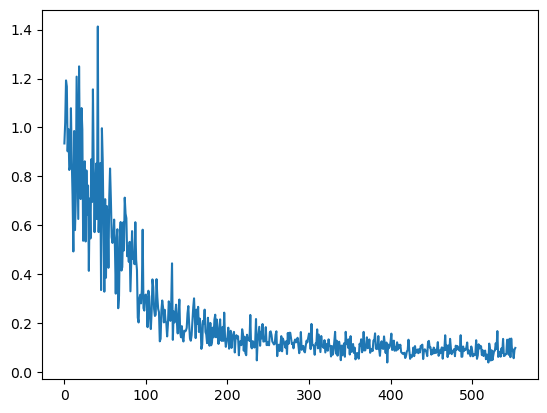

In [61]:
plt.plot(losses)
plt.show()

In [62]:
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=16, shuffle=False
)

In [63]:
model.eval()
y_preds = []
y_trues = []
losses = []
with torch.no_grad():
    for X, y in test_loader:
        pred_y = model(X)
        loss = F.mse_loss(pred_y, y)
        losses.append(loss.item())
        y_preds.append(pred_y.cpu().numpy()[0,:,0,:].reshape(-1))
        y_trues.append(y.cpu().numpy()[0,:,0,:].reshape(-1))
y_trues = np.concatenate(y_trues)
y_preds = np.concatenate(y_preds)

In [64]:
np.array(losses).mean()

0.09802100210517393

In [65]:
pred_y.shape

torch.Size([11, 3, 26, 1])

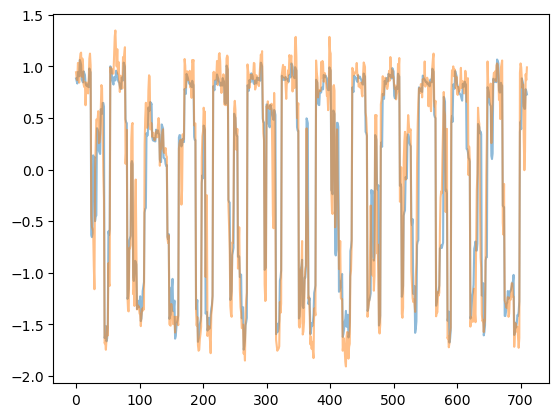

In [66]:
plt.plot(y_preds[:5000], alpha=0.5)
plt.plot(y_trues[:5000], alpha=0.5)